## Import required packages, global parameters, functions

In [8]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
from scipy import signal
import scipy as sp
from scipy import io

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as xccrs
import cartopy.feature as cfeature
%matplotlib inline
import momlevel
import datetime as dt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
from mypyutils import colormap_utils as mycolors
mdates.MonthLocator(bymonthday=15)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": 'serif',
    "font.serif": 'Computer Modern'
})    

cols=['k','C1','C0','C2','C3','C4','C5','C6']   
lines = ["-","--",":",":"]
panellabs=list(map(chr, range(97, 112)))
rotated_crs = xccrs.RotatedPole(pole_longitude=25.0, pole_latitude=70.0) # define projection!

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
##COULD GO GLOBAL!

In [10]:
import sys
sys.path.append("./../NSF-OCE_2148596/notebooks/pacific_HRDP_DPLE/lfca/Python")
from signal_processing import lfca

In [11]:
def tg_lfca(da, cutoff, truncation):
    lat_axis = da.tgindex.values
    time = da.time.values
    sst = da.to_numpy().squeeze()
    nlat = da.shape[1]
    ntime = da.shape[0]
    x = da.values
    area_weights = da[0, :] * 0 + 1
    area_weights = np.expand_dims(area_weights, axis=0)
    area_weights
    normvec = np.transpose(area_weights) / np.sum(area_weights)
    scale = np.sqrt(normvec)
    (
        lfcs,
        lfps,
        weights,
        r,
        pvar,
        pcs,
        eofs,
        ntr,
        pvar_slow,
        pvar_lfc,
        r_eofs,
        pvar_slow_eofs,
        lf_ts,
    ) = lfca(x, cutoff, truncation, scale)

    return lfcs, lfps, weights, r, pvar, pcs, eofs, ntr, pvar_slow, pvar_lfc, r_eofs, pvar_slow_eofs, lf_ts

In [12]:
def butter_bpfilt_high(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='high')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_band(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1, fc2], fs=fs, btype='band')
    return signal.filtfilt(b, a, x)
    
def butter_bpfilt_low(x,filt_year1,filt_year2,fs,order_butter):
    fc1 = filt_year1 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    fc2 = filt_year2 # cut off frequency 1sample/ 1year = (1/1)/2 equals 1 year filter (two half cycles/sample)
    b, a = signal.butter(order_butter, [fc1], fs=fs, btype='low')
    return signal.filtfilt(b, a, x)
    
def filtfilt_bpbutter_2d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["tgindex","time"], [], [], [], []],  # regrid
        output_core_dims=[["tgindex","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt    

def filtfilt_bpbutter_3d_low(x,filt_year1,filt_year2,fs,order_butter,dim='time'):
    # x ...... xr data array
    # dims .... dimension aong which to apply function   
    filt= xr.apply_ufunc(
        butter_bpfilt_low,  # first the function
        x,# now arguments in the order expected by 'butter_filt'
        filt_year1,  # as above
        filt_year2,  # as above
        fs,  # as above
        order_butter,  # as above
       
        input_core_dims=[["lat","lon","time"], [], [], [], []],  # regrid
        output_core_dims=[["lat","lon","time"]],  # returned data has 3 dimension
        # exclude_dims=set(("time",)),  # dimensions allowed to change size. Must be a set!
        vectorize=True,  # loop over non-core dims
    )
    return filt

In [13]:
def detrend_linear2(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:,:]

def detrend_linear_tg(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    da = da-fit
    return da, params.polyfit_coefficients[0,:]
    
def detrend_deseason(da): #order/fs/low pass filter unused so far
    [fosi_det, fosi_trend]=detrend_linear2(da, 'time')
    fosi_trend=fosi_trend * 1e9  * 60  * 60  * 24 * 365
    fosi_mean_sea=fosi_det.groupby("time.month").mean("time")
    # fosi_desea=fosi_det.groupby("time.month")-fosi_mean_sea
    fosi_desea=da.groupby("time.month")-fosi_mean_sea
    return fosi_desea.drop_vars('month'), fosi_trend

In [14]:
#processing functions

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    # print(x)

    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)
    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
        
    # print(x)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    # print(x,y)
    n     = x.shape[0]
    xmean = x.mean(axis=0, skipna=False)
    ymean = y.mean(axis=0, skipna=False)
    xstd  = x.std(axis=0, skipna=False)
    ystd  = y.std(axis=0, skipna=False)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope  
    
    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    # pval   = t.sf(tstats, n-2)*2
    pval = t.sf(abs(tstats), n-2)*2 #corrected
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    return cov,cor,slope,intercept,pval,stderr

## Altimetry analysis

In [15]:
datadir = '/glade/work/clittle/altimetry/MEASURES/monthly/'
alt=xr.open_mfdataset(datadir+'monthly*.nc')
alt=alt*100
alt=alt.rename({'Time': 'time','Longitude':'lon','Lon_bounds':'lon_b','Latitude':'lat','Lat_bounds':'lat_b'})
alt = alt.drop(['lon_b','lat_b'])
ds_alt=alt.sel(time=slice('1993-01-01', '2023-01-01'))
gmsl = xr.open_dataset("../NSF-OCE_2148596/notebooks/USEC_FOSI_rez_comp/gmsl_mo.nc")
gmsl=gmsl.sel(time=slice('1993-01-01', '2023-01-01'))#,Longitude=slice(xlo,xhi),Latitude=slice(ylo,yhi))
gmsl=gmsl.gmsl_variation/10

/glade/derecho/scratch/clittle/tmp/ipykernel_49715/3635674441.py:5: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  alt = alt.drop(['lon_b','lat_b'])


In [16]:
xlo=1550; xhi=2200; ylo=550; yhi=900;
da=ds_alt.SLA-gmsl
da=da.isel(lon=slice(xlo,xhi),lat=slice(ylo,yhi))#.sel(time=slice('1993-01-01','2019-1-1'))
# da['time']=xr_tg.time
da

<xarray.DataArray (time: 360, lat: 350, lon: 610)> Size: 615MB
dask.array<getitem, shape=(360, 350, 610), dtype=float64, chunksize=(120, 350, 610), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 3kB 1993-01-31 1993-02-28 ... 2022-12-31
  * lon      (lon) float32 2kB 258.4 258.6 258.8 258.9 ... 359.6 359.8 359.9
  * lat      (lat) float32 1kB 11.75 11.92 12.08 12.25 ... 69.58 69.75 69.92

In [30]:
[da_alt, datrend]=detrend_deseason(da.load())

In [20]:
pvalc=.05
ds_bathy = xr.open_dataset('/glade/work/clittle/p2521/input/'+"/obs/GEBCO.nc")

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


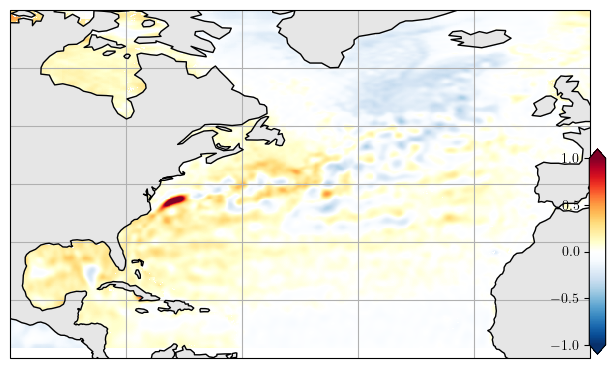

In [31]:
#altimetry trends
fig = plt.figure(figsize=(18,12), tight_layout=True)
vmin=-1
vmax=-vmin
cmap = mycolors.blue2red_cmap(20)

ax = plt.subplot2grid((1,3), (0, 0), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")

pos = ax.get_position() # get the original position 
ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
im = ax.pcolormesh(da.lon,da.lat,datrend, shading='nearest', vmin=vmin, vmax=vmax, 
# im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    
cbar_ax = fig.add_axes(
    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
)
cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
# cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=10)
ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
# ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
ax.coastlines(zorder=5)
ax.gridlines()

In [43]:
# da_alt=da_alt.rename({'lat':'TLAT','lon':'TLONG'})
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/global_hr_trend.nc')
datrend=ssh.ssh
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_hr_ssh_det.nc')

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


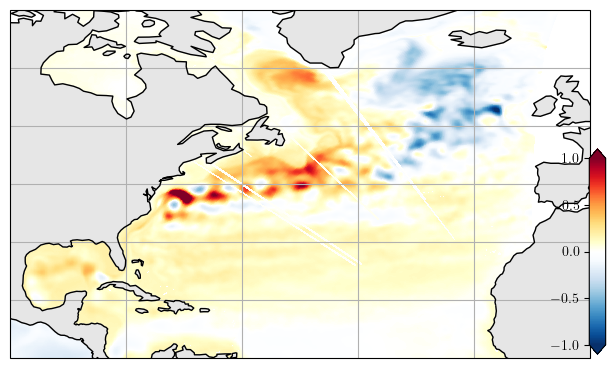

In [44]:
#altimetry trends
fig = plt.figure(figsize=(18,12), tight_layout=True)
vmin=-1
vmax=-vmin
cmap = mycolors.blue2red_cmap(20)

ax = plt.subplot2grid((1,3), (0, 0), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")

pos = ax.get_position() # get the original position 
ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
im = ax.pcolormesh(ssh.TLONG.fillna(0),ssh.TLAT.fillna(0),datrend, shading='nearest', vmin=vmin, vmax=vmax, 
# im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    
cbar_ax = fig.add_axes(
    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
)
cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
# cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=10)
ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
# ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
ax.coastlines(zorder=5)
ax.gridlines()

* Aside from main analysis: Is the altimeter trend aliasing the recent SEUS rise and the GS path? Or is that a lower-frequency element?

In [47]:
# da_alt=da_alt.rename({'lat':'TLAT','lon':'TLONG'})
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/global_lr_trend.nc')
datrend=ssh.ssh
ssh = xr.open_mfdataset('/glade/derecho/scratch/clittle/big_alpaca_lr_ssh_det.nc')

/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/glade/work/clittle/conda-envs/myorigpythonenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


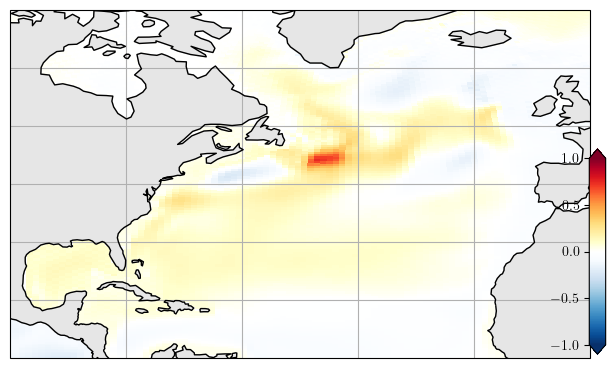

In [48]:
#altimetry trends
fig = plt.figure(figsize=(18,12), tight_layout=True)
vmin=-1
vmax=-vmin
cmap = mycolors.blue2red_cmap(20)

ax = plt.subplot2grid((1,3), (0, 0), colspan=1, rowspan=1, projection=xccrs.PlateCarree())#, aspect="auto")

pos = ax.get_position() # get the original position 
ax.set_extent([-100, 0, 10, 70], crs=xccrs.PlateCarree())
im = ax.pcolormesh(ssh.TLONG.fillna(0),ssh.TLAT.fillna(0),datrend, shading='nearest', vmin=vmin, vmax=vmax, 
# im = ax.pcolormesh(lons, lats, altrc, shading='nearest', vmin=vmin, vmax=vmax, 
            cmap=cmap,zorder=1,transform=xccrs.PlateCarree())    
cbar_ax = fig.add_axes(
    [pos.x1-(pos.x1 - pos.x0)/10, pos.y0+(pos.y1 - pos.y0)/10, (pos.x1 - pos.x0)/25, (pos.y1 - pos.y0)/2]
)
cbar = fig.colorbar(im, orientation="vertical", cax=cbar_ax, extend="both",ticklocation='left')
# cbar.ax.set_title("Reg. Coef. on PC" + str(nmode+1), rotation=0, size=10, weight="bold")
cbar.ax.tick_params(labelsize=10)
ax.add_feature(cfeature.LAND.with_scale('110m'),zorder=2,color='.9')
# ax.add_feature(cfeature.STATES, edgecolor='k',zorder=3)
ax.coastlines(zorder=5)
ax.gridlines()